In [1]:
import numpy as np
import scipy
import time
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [2]:
m, n = 500, 1000
np.random.seed(999)
W = np.random.normal(0, 1, (m, 10))
H = np.random.normal(0, 1, (10, n))
L0 = W @ H
S0 = scipy.sparse.random(m, n, 0.05).toarray()
M = L0 + S0
lam = 1 / np.sqrt(max(m, n))
max_iter = 200
tolerance = 1e-4

In [3]:
def thresholding(x, val):
    return np.sign(x) * np.where(np.abs(x) > val, np.abs(x) - val, 0)

In [4]:
def robustPCA(M, lam):
    start = time.time()
    m, n = M.shape
    sigma, eps = 0.05, 1
    L0, S0, Z0 = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    k = 0
    while k < max_iter:
        T = M - S0 - Z0/sigma
        U, d, V = np.linalg.svd(T)
        gamma = np.zeros((m, n))
        np.fill_diagonal(gamma, thresholding(d, 1/sigma))
        L1 = np.dot(np.dot(U, gamma), V)
        S1 = thresholding(M - L1 - Z0/sigma, lam/sigma)
        Z1 = Z0 + eps * sigma * (L1 + S1 - M)
        if max(np.linalg.norm(L1 - L0) / (1 + np.linalg.norm(L1)), np.linalg.norm(S1 - S0) / (1 + np.linalg.norm(S1))) < tolerance:
            return L1, S1, Z1, k, time.time() - start
        k += 1
        L0, S0, Z0 = L1, S1, Z1
    return L1, S1, Z1, k, time.time() - start


In [5]:
L, S, Z, iters, time_used = robustPCA(M, lam)
print(np.linalg.norm(L - L0))
print(np.linalg.norm(S - S0))
print(iters)
print(time_used)

0.01778679038172776
0.09416174527245899
63
6.109365940093994


## (b)

In [6]:
def robustPCA2(M, lam):
    start = time.time()
    _, d, _ = np.linalg.svd(M, full_matrices=False)
    sigma, eps, ratio = 1 / max(d), 1, 1.5
    m, n = M.shape
    L0, S0, Z0 = np.zeros((m, n)), np.zeros((m, n)), np.zeros((m, n))
    k = 0
    while k < max_iter:
        sigma = ratio * sigma
        T = M - S0 - Z0/sigma
        U, d, V = np.linalg.svd(T, full_matrices=False)
        gamma = thresholding(d, 1/sigma)
        L1 = np.dot(np.dot(U, np.diag(gamma)), V)
        S1 = thresholding(M - L1 - Z0/sigma, lam/sigma)
        Z1 = Z0 + eps * sigma * (L1 + S1 - M)
        rk = max(np.linalg.norm(L1 - L0) / (1 + np.linalg.norm(L1)), np.linalg.norm(S1 - S0) / (1 + np.linalg.norm(S1)))
        if rk < tolerance:
            return L1, S1, Z1, k, time.time() - start, rk
        k += 1
        L0, S0, Z0 = L1, S1, Z1
    return L1, S1, Z1, k, time.time() - start, rk


In [7]:
L, S, Z, iters, time_used, rk = robustPCA2(M, lam)
print(np.linalg.norm(L - L0))
print(np.linalg.norm(S - S0))
print(iters)
print(time_used)

0.001955339415222064
0.003897951021911176
21
1.656524896621704


## (c)

In [8]:
data = np.loadtxt('./BasketballPlayer.csv', delimiter=',')

In [9]:
L, S, Z, iters, time_used, rk = robustPCA2(data, 1 / np.sqrt(data.shape[0]))
print(iters)
print(time_used)
print(rk)
print(np.linalg.matrix_rank(L))
print(np.sum(S != 0))

25
373.17405796051025
7.08195219661364e-05
56
135281088


In [10]:
original = data[:, 19].reshape((1374, 918)).T
background = L[:, 19]
background = (background - np.min(background)) / (np.max(background) - np.min(background))
background = background.reshape((1374, 918)).T
foreground = S[:, 19]
foreground = (foreground - np.min(foreground)) / (np.max(foreground) - np.min(foreground))
foreground = foreground.reshape((1374, 918)).T

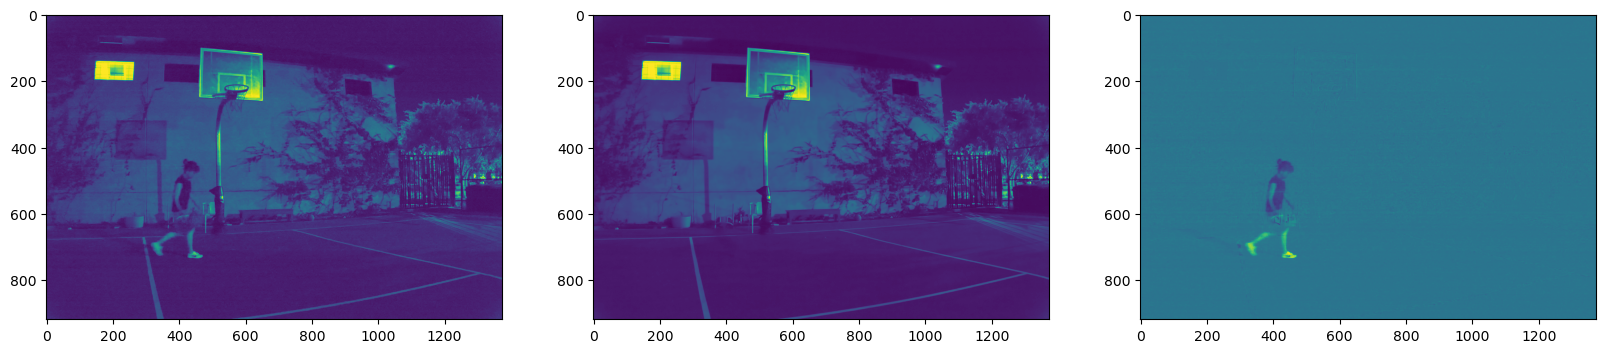

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
axs[0].imshow(original)
axs[1].imshow(background)
axs[2].imshow(foreground)

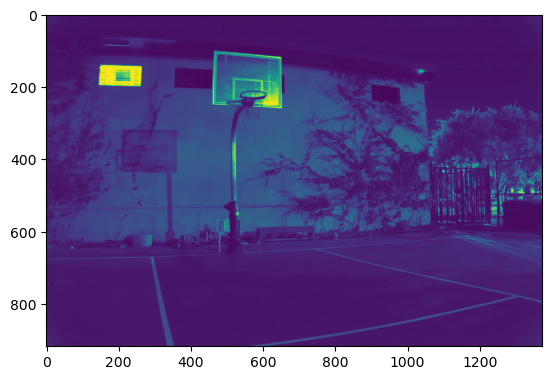

In [12]:
fig = plt.figure()
background_imgs = [L[:, i].reshape(1374, 918).T for i in range(L.shape[1])]
background_imgs = [(i - np.min(i)) / (np.max(i) - np.min(i)) for i in background_imgs]
background_frames = [[plt.imshow(i, animated = True)] for i in background_imgs]
ani_back = animation.ArtistAnimation(fig, background_frames, interval=50, repeat_delay=1000)
ani_back.save('background_video.mp4', writer = 'ffmpeg', fps = 24)
plt.show()

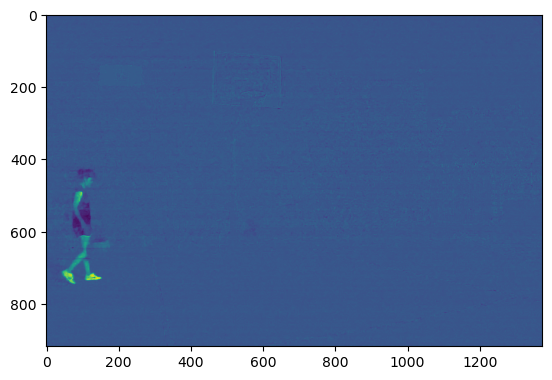

In [13]:
fig = plt.figure()
foreground_imgs = [S[:, i].reshape(1374, 918).T for i in range(S.shape[1])]
foreground_imgs = [(i - np.min(i)) / (np.max(i) - np.min(i)) for i in foreground_imgs]
foreground_frames = [[plt.imshow(i, animated = True)] for i in foreground_imgs]
ani_fore = animation.ArtistAnimation(fig, foreground_frames, interval=50, repeat_delay=1000)
ani_fore.save('foreground_video.mp4', writer = 'ffmpeg', fps = 24)
plt.show()